In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from orbit.models import DLT
from datetime import timedelta

# --- Step 1: Load data ---
def read_and_clean(filepath):
    df = pd.read_csv(filepath)
    df.date = pd.to_datetime(df.date)
    df.columns = ['date','PM25','PM10','O3','NO2','SO2','CO']

    df.replace('Missing value', pd.NA, inplace=True)

    df['date'] = pd.to_datetime(df['date'])

    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.sort_values('date', ascending=True)

    return df

In [19]:
train_df = read_and_clean('data/baotou-training.csv').dropna()
test_df = read_and_clean('data/baotou-testing.csv')
btu_df = read_and_clean('data/baotou.csv')

/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_26492/316328749.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.date = pd.to_datetime(df.date)
/var/folders/n0/qhjx1vrd1c1b846x7pqgmbg40000gn/T/ipykernel_26492/316328749.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.date = pd.to_datetime(df.date)


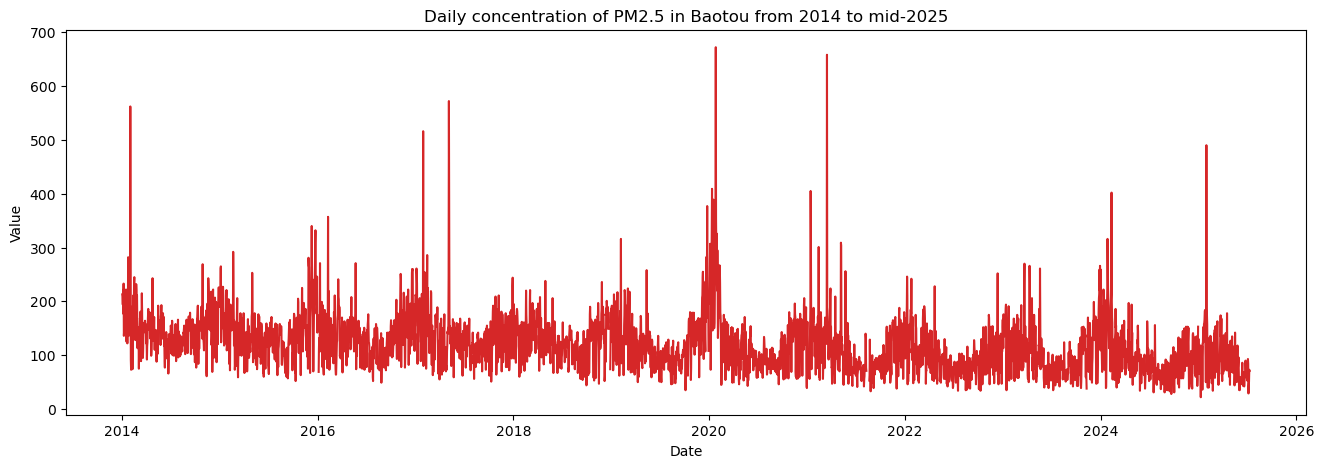

In [20]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value'):
    plt.figure(figsize=(16,5))
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(btu_df, x=btu_df.date, y=btu_df.PM25, title='Daily concentration of PM2.5 in Baotou from 2014 to mid-2025')

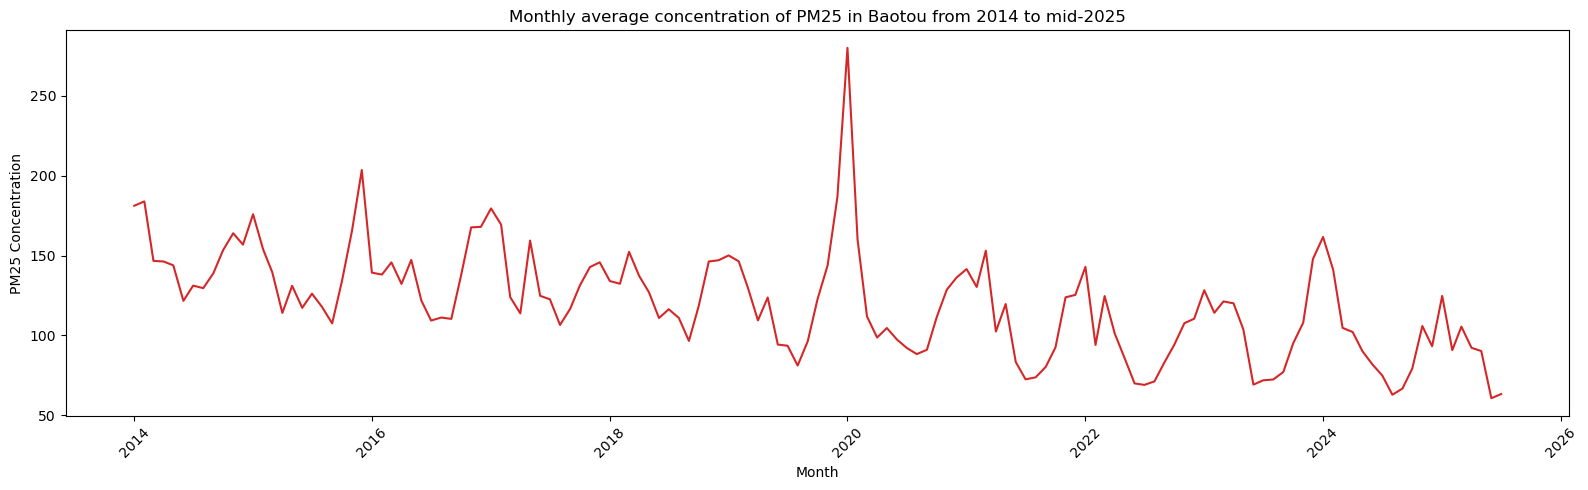

In [21]:
def monthlyAverage(df, city_name, pollutant):
    monthly_df = df.copy()
    monthly_df['year_month'] = monthly_df.date.dt.to_period('M').dt.to_timestamp()

    # Group by the new monthly date
    monthly_avg = monthly_df.groupby('year_month')[pollutant].mean().reset_index()

    def plot_df(x, y, title="", xlabel='Date', ylabel='Value'):
        plt.figure(figsize=(16, 5))
        plt.plot(x, y, color='tab:red')
        plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    plot_df(
        x=monthly_avg['year_month'],
        y=monthly_avg[pollutant],
        title='Monthly average concentration of {pollutant} in {city_name} from 2014 to mid-2025'.format(pollutant=pollutant, city_name=city_name),
        xlabel='Month',
        ylabel='{pollutant} Concentration'.format(pollutant=pollutant)
)

monthlyAverage(btu_df, 'Baotou', 'PM25')

In [22]:
def detect_seasonality(df):
    date_diffs = df['date'].diff().dt.days.dropna()
    median_diff = date_diffs.median()

    if median_diff <= 1.1:
        return 365
    elif median_diff <= 8:
        return 52
    elif median_diff <= 31:
        return 12
    else:
        return 12

seasonality_value = detect_seasonality(train_df)

In [23]:
model = DLT(
    date_col="date",
    response_col="PM25",
    seasonality=seasonality_value,
    seed=42,
    verbose=1
)

In [24]:
model.fit(train_df)

/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-14 13:12:58 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [25]:
predicted_df = model.predict(test_df)

In [26]:
merged_df = predicted_df.merge(test_df, on="date", how="left")
merged_df = merged_df.rename(columns={"PM25": "actual", "prediction": "predicted"})

mae = mean_absolute_error(merged_df["actual"], merged_df["predicted"])

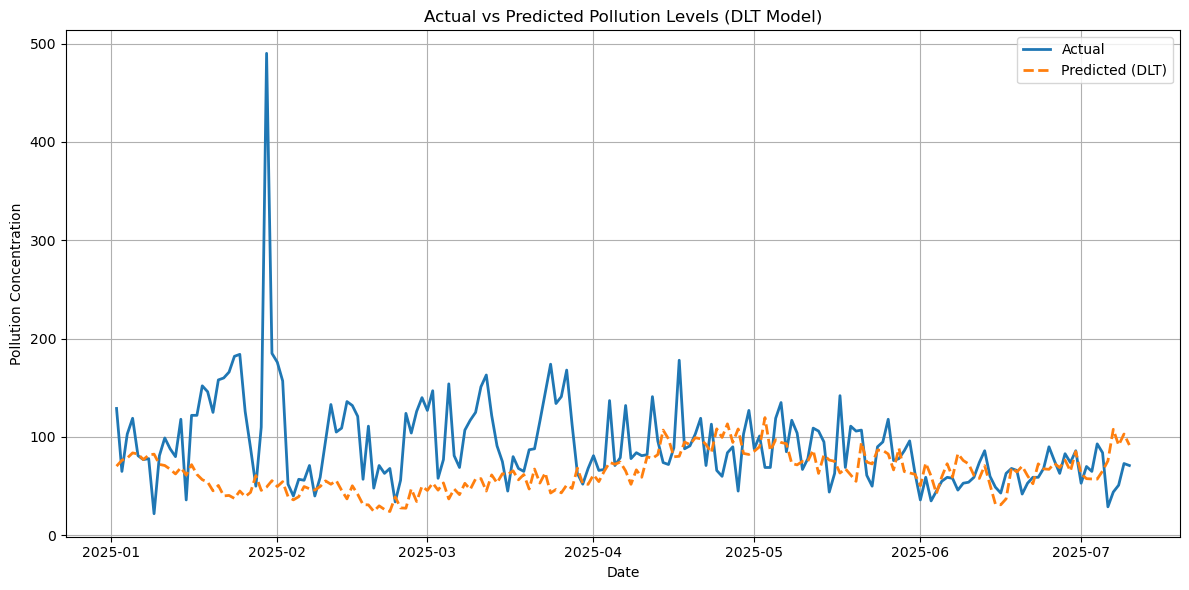

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df["date"], merged_df["actual"], label="Actual", linewidth=2)
plt.plot(merged_df["date"], merged_df["predicted"], label="Predicted (DLT)", linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Pollution Levels (DLT Model)")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-14 13:14:07 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Forecasting through 2025-12-31...


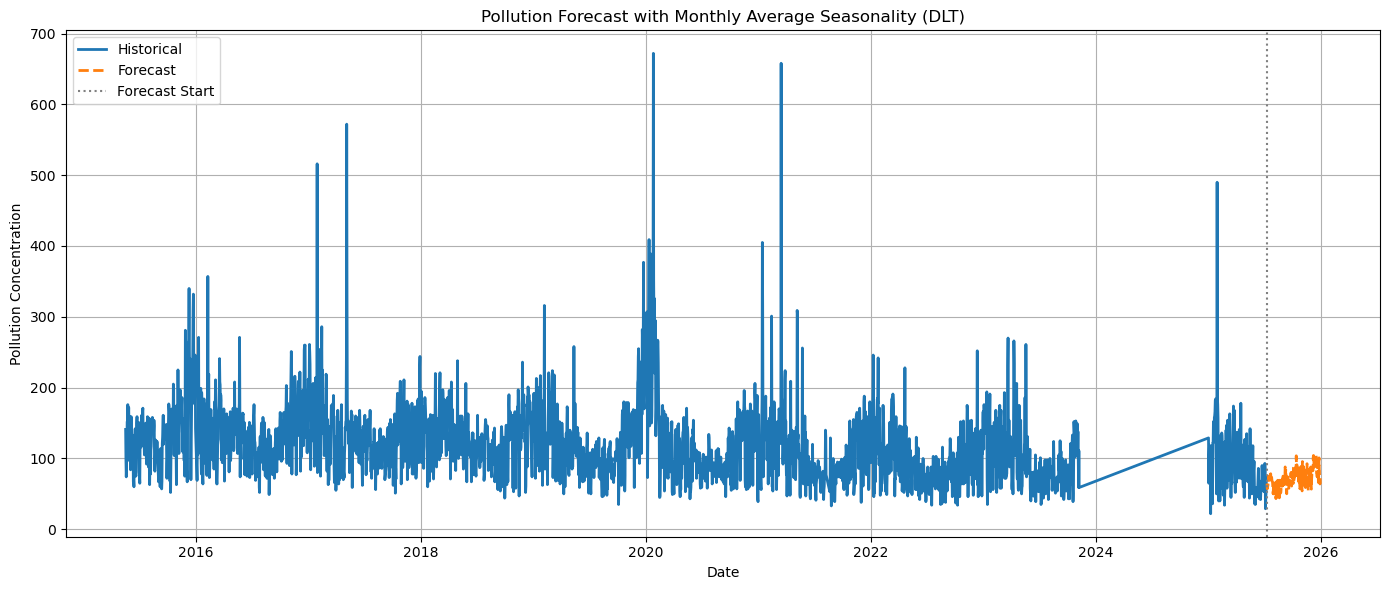

In [28]:
# Combine
full_df = pd.concat([train_df, test_df], ignore_index=True)

# --- Compute Monthly Averages ---
monthly_avg = full_df.copy()
monthly_avg['month'] = monthly_avg['date'].dt.month
monthly_profile = monthly_avg.groupby('month')['PM25'].mean().rename('monthly_avg')

# --- Add Monthly Average as Regressor ---
def add_monthly_regressor(df):
    df = df.copy()
    df['month'] = df['date'].dt.month
    df = df.merge(monthly_profile, left_on='month', right_index=True, how='left')
    return df.drop(columns=['month'])

full_df = add_monthly_regressor(full_df)

# Forecast period
last_date = full_df['date'].max()
end_of_year = pd.Timestamp(f"{last_date.year}-12-31")
n_days = (end_of_year - last_date).days
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=n_days)
future_df = pd.DataFrame({'date': future_dates})
future_df = add_monthly_regressor(future_df)

# --- Fit DLT with Monthly Regressor ---
model = DLT(
    date_col="date",
    response_col="PM25",
    regressor_col=["monthly_avg"],
    seasonality=365,
    seed=42,
    verbose=1
)

model.fit(full_df)

# --- Forecast ---
print(f"Forecasting through {end_of_year.date()}...")
forecast_df = model.predict(future_df)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(full_df["date"], full_df["PM25"], label="Historical", linewidth=2)
plt.plot(forecast_df["date"], forecast_df["prediction"], label="Forecast", linestyle="--", linewidth=2)
plt.axvline(last_date, color='gray', linestyle=':', label="Forecast Start")
plt.title("Pollution Forecast with Monthly Average Seasonality (DLT)")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-14 13:15:25 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


Fitting DLT on full data for long-term forecasting...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Forecasting until 2030-12-31...


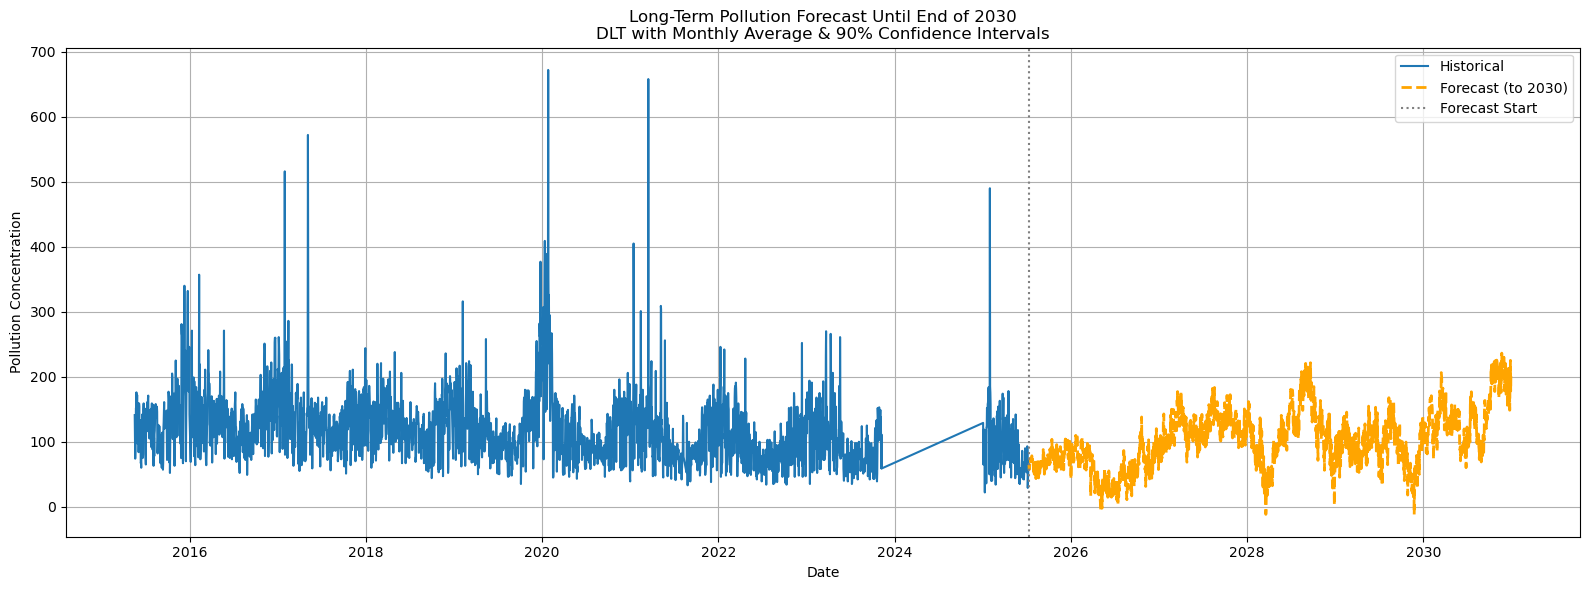

In [29]:
from datetime import datetime

# --- Update forecast horizon ---
forecast_horizon = pd.date_range(
    start=last_date + timedelta(days=1),
    end=pd.Timestamp("2030-12-31"),
    freq='D'
)

# Create future DataFrame and assign monthly average
future_df_long = pd.DataFrame({'date': forecast_horizon})
future_df_long = add_monthly_regressor(future_df_long)

# --- Retrain model on full dataset with monthly regressor ---
model = DLT(
    date_col="date",
    response_col="PM25",
    regressor_col=["monthly_avg"],
    seasonality=365,
    seed=42,
    verbose=1
)

print("Fitting DLT on full data for long-term forecasting...")
model.fit(full_df)

# --- Predict future pollution levels to 2030 ---
print("Forecasting until 2030-12-31...")
# --- Forecast with prediction intervals ---
forecast_long_df = model.predict(future_df_long, include_ci=True)

# --- Plot ---
plt.figure(figsize=(16, 6))
plt.plot(full_df["date"], full_df["PM25"], label="Historical", linewidth=1.5)
plt.plot(forecast_long_df["date"], forecast_long_df["prediction"],
         label="Forecast (to 2030)", linestyle="--", linewidth=2, color='orange')

plt.axvline(last_date, color='gray', linestyle=':', label="Forecast Start")
plt.title("Long-Term Pollution Forecast Until End of 2030\nDLT with Monthly Average & 90% Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
import numpy as np

# --- Parameters ---
forecast_start = pd.to_datetime(last_date)
decay_rate = 0.02  # Decay rate per year (adjust to control intensity)

# --- Compute decay factor ---
days_since_start = (forecast_long_df["date"] - forecast_start).dt.days
years_since_start = days_since_start / 365.25
decay_factor = np.exp(-decay_rate * years_since_start)

# --- Apply decay to forecast and confidence intervals ---
forecast_long_df["prediction_decay"] = forecast_long_df["prediction"] * decay_factor
forecast_long_df["prediction_5_decay"] = forecast_long_df["prediction_5"] * decay_factor
forecast_long_df["prediction_95_decay"] = forecast_long_df["prediction_95"] * decay_factor

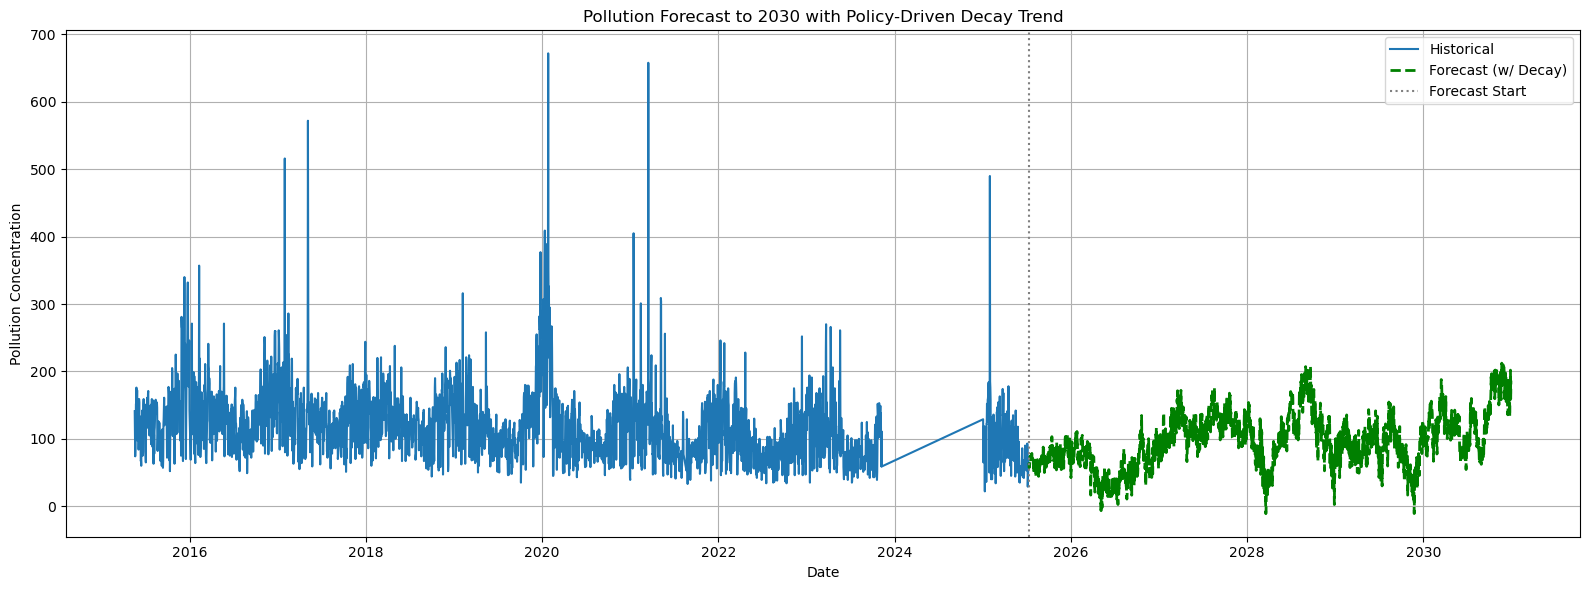

In [31]:
plt.figure(figsize=(16, 6))
plt.plot(full_df["date"], full_df["PM25"], label="Historical", linewidth=1.5)
plt.plot(forecast_long_df["date"], forecast_long_df["prediction_decay"],
         label="Forecast (w/ Decay)", linestyle="--", linewidth=2, color='green')

plt.axvline(forecast_start, color='gray', linestyle=':', label="Forecast Start")
plt.title("Pollution Forecast to 2030 with Policy-Driven Decay Trend")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-14 13:18:40 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


Fitting DLT on full data with decay trend...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Forecasting until 2030-12-31 with decay trend...


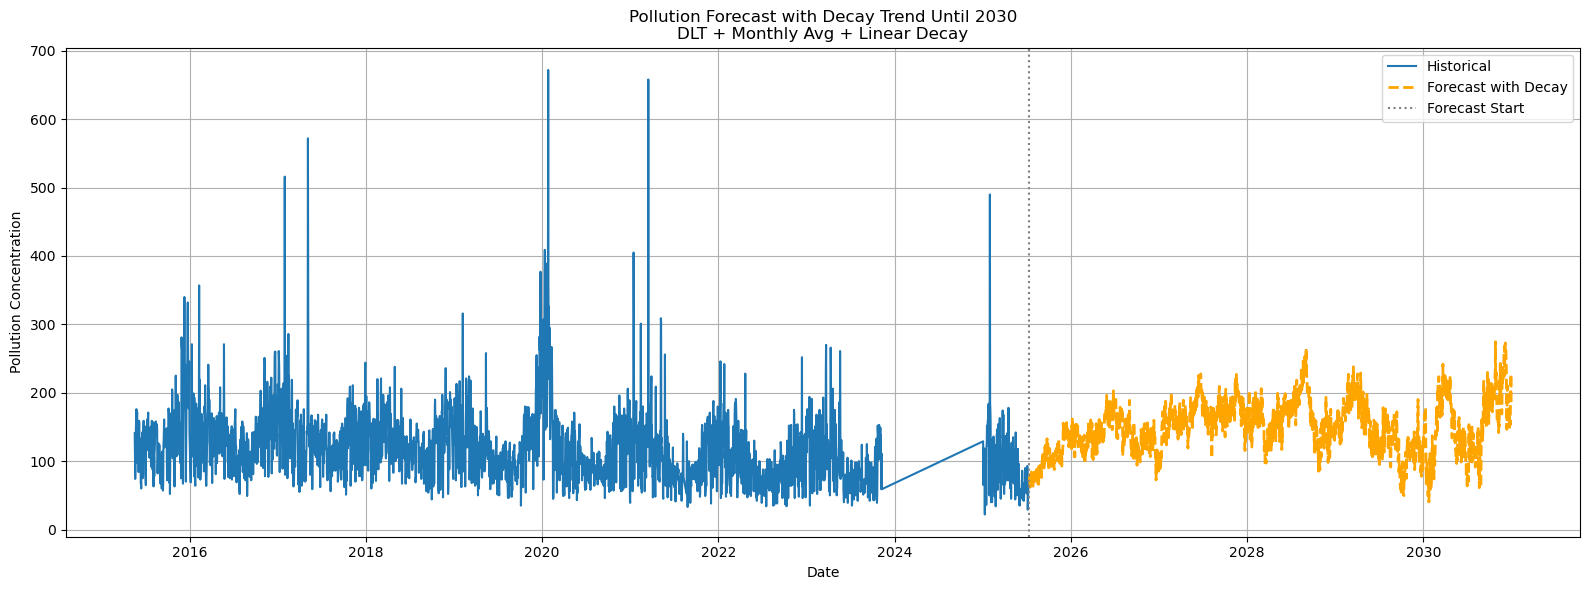

In [32]:
from datetime import datetime, timedelta
import numpy as np

# --- Update forecast horizon ---
forecast_horizon = pd.date_range(
    start=last_date + timedelta(days=1),
    end=pd.Timestamp("2030-12-31"),
    freq='D'
)

# --- Create future DataFrame ---
future_df_long = pd.DataFrame({'date': forecast_horizon})
future_df_long = add_monthly_regressor(future_df_long)

# --- Add decay regressor (linearly decreasing from 1 to 0) ---
total_days = (future_df_long['date'].max() - future_df_long['date'].min()).days
future_df_long['decay_trend'] = np.linspace(1, 0, total_days + 1)

# --- Also add decay to historical data (linearly from 1 to point of forecast start) ---
historical_days = (full_df['date'].max() - full_df['date'].min()).days
full_df['decay_trend'] = np.linspace(1, 1 - (len(full_df) / (len(full_df) + len(future_df_long))), len(full_df))

# --- Retrain model with decay trend ---
model = DLT(
    date_col="date",
    response_col="PM25",
    regressor_col=["monthly_avg", "decay_trend"],
    seasonality=365,
    seed=42,
    verbose=1
)

print("Fitting DLT on full data with decay trend...")
model.fit(full_df)

# --- Forecast ---
print("Forecasting until 2030-12-31 with decay trend...")
forecast_long_df = model.predict(future_df_long, include_ci=True)

# --- Plot ---
plt.figure(figsize=(16, 6))
plt.plot(full_df["date"], full_df["PM25"], label="Historical", linewidth=1.5)
plt.plot(forecast_long_df["date"], forecast_long_df["prediction"],
         label="Forecast with Decay", linestyle="--", linewidth=2, color='orange')
plt.axvline(last_date, color='gray', linestyle=':', label="Forecast Start")
plt.title("Pollution Forecast with Decay Trend Until 2030\nDLT + Monthly Avg + Linear Decay")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2025-07-14 13:28:52 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


Fitting DLT on full data with decay trend...


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Forecasting until 2030-12-31 with decay trend...


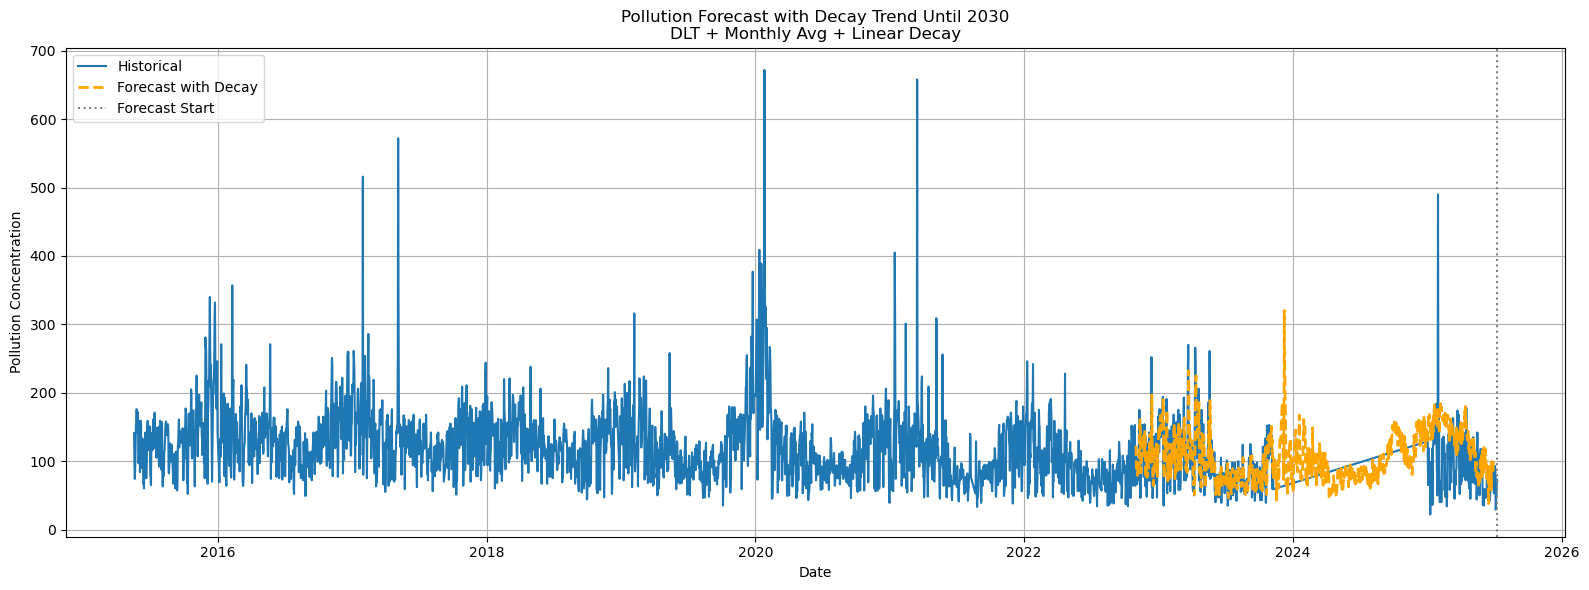

In [34]:
from datetime import datetime, timedelta
import numpy as np

# --- Update forecast horizon ---
forecast_horizon = pd.date_range(
    start=pd.Timestamp("2022-10-31") + timedelta(days=1),
    end=pd.Timestamp("2025-06-30"),
    freq='D'
)

# --- Create future DataFrame ---
future_df_long = pd.DataFrame({'date': forecast_horizon})
future_df_long = add_monthly_regressor(future_df_long)

# --- Add decay regressor (linearly decreasing from 1 to 0) ---
total_days = (future_df_long['date'].max() - future_df_long['date'].min()).days
future_df_long['decay_trend'] = np.linspace(1, 0, total_days + 1)

# --- Also add decay to historical data (linearly from 1 to point of forecast start) ---
historical_days = (full_df['date'].max() - full_df['date'].min()).days
full_df['decay_trend'] = np.linspace(1, 1 - (len(full_df) / (len(full_df) + len(future_df_long))), len(full_df))

# --- Retrain model with decay trend ---
model = DLT(
    date_col="date",
    response_col="PM25",
    regressor_col=["monthly_avg", "decay_trend"],
    seasonality=365,
    seed=42,
    verbose=1
)

print("Fitting DLT on full data with decay trend...")
model.fit(full_df)

# --- Forecast ---
print("Forecasting until 2030-12-31 with decay trend...")
forecast_long_df = model.predict(future_df_long, include_ci=True)

# --- Plot ---
plt.figure(figsize=(16, 6))
plt.plot(full_df["date"], full_df["PM25"], label="Historical", linewidth=1.5)
plt.plot(forecast_long_df["date"], forecast_long_df["prediction"],
         label="Forecast with Decay", linestyle="--", linewidth=2, color='orange')
plt.axvline(last_date, color='gray', linestyle=':', label="Forecast Start")
plt.title("Pollution Forecast with Decay Trend Until 2030\nDLT + Monthly Avg + Linear Decay")
plt.xlabel("Date")
plt.ylabel("Pollution Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
